In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

sns.set_style('darkgrid')
titleFont = FontProperties(weight='bold', size=20)
axisFont = FontProperties(weight='bold', size=14) 

from trading.exchange import BackTestExchange
from trading.dataManager import CurrencyDataManager
from trading.money.contract import ContractPair, Contract
from trading.statistics import Statistics
from trading.money.transaction import BuyTransaction, SellTransaction
from calculator.talibWrapper import calculateTalib

# Load Data

In [26]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataLabeled\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('timestamp').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair('usdt', 'btc')

# Distance From Max

In [40]:
from copy import deepcopy

class DistanceFromMaxStrategy:
    def __init__(self, exchange, dataManager, historyLen, contractPair, tradeSize, willingLoss, 
                 distanceFromMaxThreshold, targetProfit):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.historyLen = historyLen
        self.contractPair = contractPair
        self.opened = False
        self.tradeSize = tradeSize
        self.willingLoss = willingLoss
        self.distanceFromMaxThreshold = distanceFromMaxThreshold
        self.targetProfit = targetProfit
    
    
    def isRisky(self, priceBought, actualPrice):
        return self.currentReturn(priceBought, actualPrice) < -self.willingLoss 
    
    
    def currentReturn(self, priceBought, actualPrice):
        return float(actualPrice - priceBought) / priceBought
    
    
    def sellWhole(self, price):
        self.opened = False
        amount = self.exchange.balance(self.contractPair.tradeContract)
        self.exchange.sell(self.contractPair, amount, price)
    
    
    def buy(self, price):
        amount = self.tradeSize / price
        self.exchange.buy(self.contractPair, amount, price)
        self.opened = True
        
        fee = self.exchange.fee
        breakEvenPrice = price + price * fee * 2 + price * (fee ** 2)
        return breakEvenPrice
        
    
    def isTargetSatisffied(self, priceBought, price):
        return self.currentReturn(priceBought, price) >= self.targetProfit
    
    
    def trade(self):
        
        wasBellow = False
        while self.dataManager.hasTick():            
            history, price = self.dataManager.tick(self.historyLen)
            if history.shape[0] < self.historyLen:
                continue

            closeMax = history['close'].max()
            distanceFromMax = (closeMax - price) / price
#             print(history.shape[0], distanceFromMax, closeMax, price)
            if not self.opened and distanceFromMax >= self.distanceFromMaxThreshold:
#                 print(self.dataManager.time, 'openning trade: ', price, end='\t')
                breakEvenPrice = self.buy(price)
                priceBought = price                
            elif self.opened and self.isRisky(priceBought, price):
#                 print(self.dataManager.time, 'stopLoss: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
            elif self.opened and self.isTargetSatisffied(breakEvenPrice, price):
#                 print(self.dataManager.time, 'profit: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)

                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)

# Learning

In [37]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = DistanceFromMaxStrategy(exchange, dataManager, 3*288, contractPair, 100, willingLoss=0.5, 
                                   distanceFromMaxThreshold=0.1, targetProfit=0.01)
strategy.trade()
strategy.stats('usdt').report()

1317 openning trade:  1025.0	10754 profit:  1041.0 1.0550686722158118
11407 openning trade:  960.00000029	11408 profit:  996.99999999 3.3368365960434425
11411 openning trade:  970.0	11414 profit:  988.21302352 1.3701469923412382
11416 openning trade:  965.09999999	11436 profit:  979.99999999 1.0380596768197348
11439 openning trade:  970.52325411	11532 profit:  987.00000001 1.1911296927396138
11540 openning trade:  978.18000519	11782 profit:  993.0 1.0093798317772165
15650 openning trade:  1111.85144703	15651 profit:  1153.35959977 3.216518579779081
19105 openning trade:  1168.3260992	19119 profit:  1192.8 1.5862173664494297
19264 openning trade:  1165.0000009999999	19409 profit:  1183.0 1.039236612229305
19441 openning trade:  1164.88000019	19485 profit:  1182.89999648 1.0411031161708018
19850 openning trade:  1109.2000001	19888 profit:  1129.39687905 1.313649511137685
19889 openning trade:  1121.00000009	19906 profit:  1139.99999997 1.188341110710997
19907 openning trade:  1140.719999

,usdt
startAmount,"1,000.0000"
numberOfTrades,79.0000
totalProfit,106.3308
avgProfit,1.3460
winPercentage,100.0000
avgWinTrade,1.3460
avgLossTrade,0.0000
profitFactor,inf
maxDrawdown,0.0000


In [42]:
import time, sys
DAY = 288

allStats = None
for historyLen in [DAY, 2*DAY, 3*DAY, 5*DAY]:
    for willingLoss in [.01, .03, .05, .1, .2, .4, .5]:
        for distanceFromMaxThreshold in [.01, .02, .05, .07, .1, .2, .3, .5]:
            for targetProfit in [.01, .02, .05, .07, .1, .2, .3, .5]:
                print('historyLen:', historyLen, end='\t')
                print('willingLoss', willingLoss, end='\t')
                print('distanceFromMaxThreshold', distanceFromMaxThreshold, end='\t')
                print('targetProfit', targetProfit, end='\t')
                sys.stdout.flush()
                
                start_time = time.time()
                dataManager = deepcopy(usdtBtcManagerTrain)
                exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
                strategy = DistanceFromMaxStrategy(exchange, dataManager, historyLen, contractPair, 100, willingLoss=willingLoss, 
                                   distanceFromMaxThreshold=distanceFromMaxThreshold, targetProfit=targetProfit)
                strategy.trade()
                stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
                stats['historyLen'] = historyLen
                stats['willingLoss'] = willingLoss
                stats['distanceFromMaxThreshold'] = distanceFromMaxThreshold
                stats['targetProfit'] = targetProfit
                if allStats is None:
                    allStats = stats
                else:
                    allStats = allStats.append(stats)
                print("%.2f seconds" % (time.time() - start_time))
                break
# allStats.to_csv('distanceFromMaxResult.tsv', index=False, sep='\t')

historyLen: 288	willingLoss 0.01	distanceFromMaxThreshold 0.01	targetProfit 0.01	44.79 seconds
historyLen: 288	willingLoss 0.01	distanceFromMaxThreshold 0.02	targetProfit 0.01	

KeyboardInterrupt: 

# Look on transactions

In [66]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotTransaction(transaction, i):
    color = 'k' if type(transaction) == BuyTransaction else 'm'
    plt.scatter(i, transaction.price.value, s=200, c=color)
    

def plotMax(mmax, i):
    plt.scatter(i, mmax, s=200, c='b')

    
def indexRange(i, offsetBack, offsetForward, length):
    start = i - offsetBack if i - offsetBack > 0 else 0
    end = i + offsetForward if i + offsetForward < length else length-1
    return start, end
    
def plotTransactionWithSurroundings(prices, timePeriod, transaction):
    i = transaction.timestamp
    start,end = indexRange(i, 40, 20, prices.shape[0])
    selected = prices.iloc[start:end, :].reset_index()
    
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    
    mmax = prices.iloc[start:i, :]['close'].max()
    plotMax(mmax, 39)
    

In [63]:
len(strategy.exchange.transactions)

1304

1186.98999999
1180.79999998


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


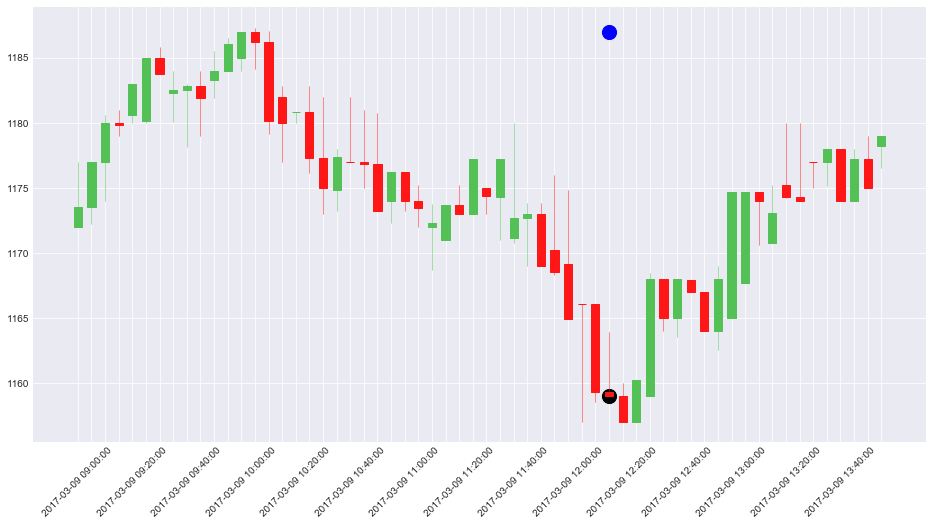

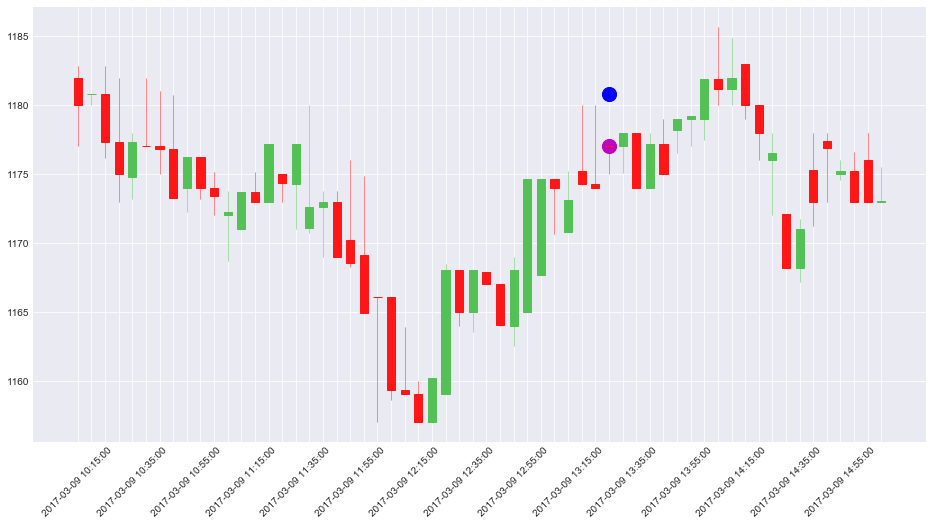

In [65]:
t = 506

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(usdtBtcTrain, strategy.historyLen, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(usdtBtcTrain, strategy.historyLen, transaction)

In [ ]:
transaction

# Evaluate Distance From Max

In [6]:
allStats = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\result\\bbandsResult.tsv',sep='\t')

In [16]:
allStats.query('totalProfit > 90 and winPercentage > 50').sort_values('numberOfTrades', ascending=False)

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,historyLen,willingLoss,distFromMiddleThreshold,diffThreshold
273,usdt,"1,000.0000",56.0000,101.8809,1.8193,57.1429,6.0826,-3.8651,2.0983,2.3395,30,0.0300,0.0200,0.0100
205,usdt,"1,000.0000",10.0000,93.2724,9.3272,60.0000,46.0404,-20.6800,3.3395,2.6947,20,0.2000,0.0500,0.0200
206,usdt,"1,000.0000",10.0000,97.4533,9.7453,60.0000,46.7573,-20.7102,3.3865,3.1522,20,0.2000,0.0500,0.0300
79,usdt,"1,000.0000",9.0000,115.9220,12.8802,55.5556,59.7695,-20.6689,3.6147,2.3965,15,0.2000,0.0500,0.0200
80,usdt,"1,000.0000",9.0000,123.5979,13.7331,55.5556,61.3324,-20.7035,3.7030,2.5426,15,0.2000,0.0500,0.0300
204,usdt,"1,000.0000",9.0000,90.1667,10.0185,66.6667,42.0064,-20.5405,4.0901,2.0512,20,0.2000,0.0500,0.0100
78,usdt,"1,000.0000",8.0000,107.7693,13.4712,62.5000,53.9215,-20.5294,4.3776,2.0479,15,0.2000,0.0500,0.0100
96,usdt,"1,000.0000",5.0000,99.2789,19.8558,100.0000,39.9058,0.0000,inf,0.0000,15,0.4000,0.0500,0.0100
114,usdt,"1,000.0000",5.0000,99.2789,19.8558,100.0000,39.9058,0.0000,inf,0.0000,15,0.5000,0.0500,0.0100


In [8]:
dataManager = deepcopy(usdtBtcManagerTest)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = BollingerBandsStrategy(exchange, dataManager, 30, contractPair, 100, willingLoss=0.03, distFromMiddleThreshold=0.02, diffThreshold=0.01)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,21.0000
totalProfit,260.8806
avgProfit,12.4229
winPercentage,61.9048
avgWinTrade,42.9565
avgLossTrade,-37.1942
profitFactor,1.8768
maxDrawdown,6.7830
